In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
import xarray as xr
import polars as pl
import glob
import torch 
import torch.nn as nn 
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split

# Defining our XGBRegressor model to be computed using CPU
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from keras_unet_collection import models
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

import time

2024-05-30 21:06:15.524041: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 21:06:15.524432: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 21:06:15.527936: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 21:06:15.561338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 21:06:16.308085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

# Some constants:

In [2]:
data_dir = '/home/hawbecker/kaggle/LEAP'

num_locs = 384 # From the test file
total_len = 625000 # size of training set
train_size = 400000 # amount of data from training set we use for training
test_size = total_len - train_size
batch_size = num_locs * 10

train_data_file = os.path.join(data_dir,'train.csv')
test_data_file = os.path.join(data_dir,'test.csv')
submission_file = os.path.join(data_dir,'sample_submission.csv')

# Load in the data:

In [3]:
#### Sample data:
sample_ds = xr.open_dataset(os.path.join(data_dir,'ClimSim_low-res_grid-info.nc'))

lat = sample_ds.lat
lon = sample_ds.lon
ak = sample_ds.hyam
bk = sample_ds.hybm
stride = len(lat)

In [4]:
# Sample 100 rows of data to determine dtypes.
df_test = pd.read_csv(train_data_file, nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

# Get the 2D and 3D variable names:

In [5]:
# Get 2d / 3d variables:
with open(train_data_file,'r') as f:
    header = f.readline().split(',')

Xvars_2d = []
Xvars_3d = []

Yvars_2d = []
Yvars_3d = []

for col in header[1:]:
    col = col.replace('\n','')
    col = col.split('_')
    if (len(col) == 3) & (col[-1].isnumeric()): # 3-D
        if col[0] == 'ptend': # Targets
            Yvars_3d += ['_'.join(col[:2])]
        else: # Features
            Xvars_3d += ['_'.join(col[:2])]
    else: # 2-D
        if col[1] == 'out': # Targets:
            Yvars_2d += ['_'.join(col)]
        else: # Features
            Xvars_2d += ['_'.join(col)]
Xvars_3d = list(np.unique(Xvars_3d))
Yvars_3d = list(np.unique(Yvars_3d))
print(Xvars_3d)
print(Yvars_3d)

['pbuf_CH4', 'pbuf_N2O', 'pbuf_ozone', 'state_q0001', 'state_q0002', 'state_q0003', 'state_t', 'state_u', 'state_v']
['ptend_q0001', 'ptend_q0002', 'ptend_q0003', 'ptend_t', 'ptend_u', 'ptend_v']


In [6]:
print(Xvars_2d)
print(Yvars_2d)

['state_ps', 'pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX', 'pbuf_TAUX', 'pbuf_TAUY', 'pbuf_COSZRS', 'cam_in_ALDIF', 'cam_in_ALDIR', 'cam_in_ASDIF', 'cam_in_ASDIR', 'cam_in_LWUP', 'cam_in_ICEFRAC', 'cam_in_LANDFRAC', 'cam_in_OCNFRAC', 'cam_in_SNOWHLAND']
['cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']


In [7]:
vars_3d = Xvars_3d + Yvars_3d
vars_2d = Xvars_2d + Yvars_2d

# Load in processed data:

In [8]:
proc_data_dir = os.path.join(data_dir,'processed_data')
proc_x_files = sorted(glob.glob(os.path.join(proc_data_dir,'train_data_X*')))
proc_y_files = sorted(glob.glob(os.path.join(proc_data_dir,'train_data_Y*')))

In [9]:
X_train = xr.open_mfdataset(proc_x_files[:4])
Y_train = xr.open_mfdataset(proc_y_files[:4])
X_val = xr.open_mfdataset(proc_x_files[4:7])
Y_val = xr.open_mfdataset(proc_y_files[4:7])

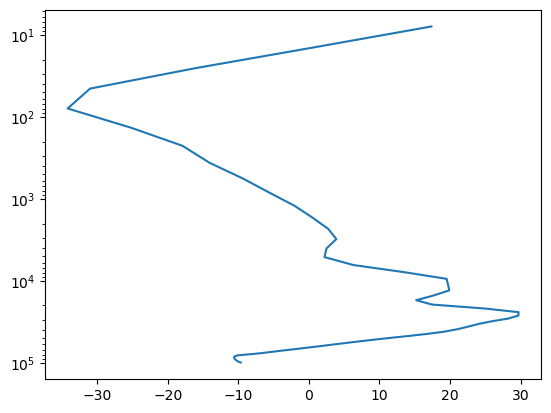

In [10]:
fig,ax = plt.subplots()
plt.plot(X_train.state_u.isel(point=99),X_train.state_p.isel(point=99))
plt.gca().invert_yaxis()
ax.set_yscale('log')

# Scale / Normalize the data:

In [11]:
# Pre-Processing - Standard Scaling our Cleaned Features
X_train = X_train.load()
X_train_scaled = X_train.copy()*1.0
scaler = StandardScaler()
for lvl in X_train.level:
    data = X_train.sel(level=lvl).to_array().T
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    for vv,varn in enumerate(list(X_train.data_vars)):
        X_train_scaled[varn].sel(level=lvl)[:] = scaled_data[:,vv]

In [12]:
X_val = X_val.load()

# Pre-Processing - Standard Scaling our Cleaned Features
X_val_scaled = X_val.copy()*1.0
for lvl in X_val.level:
    data = X_val.sel(level=lvl).to_array().T
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    for vv,varn in enumerate(list(X_val.data_vars)):
        X_val_scaled[varn].sel(level=lvl)[:] = scaled_data[:,vv]

In [55]:
# Pre-Processing - Standard Scaling our Cleaned Features
Y_train_scaled = Y_train.copy()*1.0
scaler = StandardScaler()
for lvl in Y_train.level:
    data = Y_train.sel(level=lvl).to_array().T
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    for vv,varn in enumerate(list(Y_train.data_vars)):
        Y_train_scaled[varn].sel(level=lvl).data = scaled_data[:,vv]

In [56]:
# Pre-Processing - Standard Scaling our Cleaned Features
Y_val_scaled = Y_val.copy()*1.0
scaler = StandardScaler()
for lvl in Y_val.level:
    data = Y_val.sel(level=lvl).to_array().T
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    for vv,varn in enumerate(list(Y_val.data_vars)):
        Y_val_scaled[varn].sel(level=lvl).data = scaled_data[:,vv]

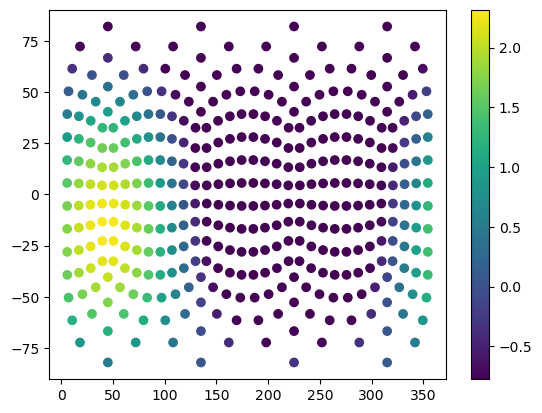

In [57]:
slice_num = 45
slice_s = slice_num*num_locs
slice_e = slice_s + num_locs
plt.scatter(lon,lat,c=X_train_scaled.pbuf_SOLIN.isel(point=slice(slice_s,slice_e),level=50))
plt.colorbar()

In [58]:
# Loading a single Batch of training samples into data variable
#data = train_df.next_batches(1)[0]   
# Variable Names for Feature and Prediction Columns
fixed_targets = ['ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7',
                 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11',
                 'ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3',
                 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7',
                 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11',
                 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15',
                 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19',
                 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 
                 'ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3',
                 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7',
                 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11',
                 'ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4',
                 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9',
                 'ptend_u_10', 'ptend_u_11', 'ptend_v_0', 'ptend_v_1', 'ptend_v_2',
                 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7',
                 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11']

In [59]:
#make matrices for training/validation
split_ind = 75

data_order = ()

X_t = X_train_scaled.to_array().transpose('point','level','variable')
y_t = Y_train_scaled.to_array().transpose('point','level','variable')
X_v = X_val_scaled.to_array().transpose('point','level','variable')
y_v = Y_val_scaled.to_array().transpose('point','level','variable')

In [60]:
np.asarray(X_val.mean(dim='point').state_t.data)

array([216.64271166, 230.65410909, 239.66404736, 249.18113538,
       257.19330171, 260.31345591, 256.5751961 , 248.43615746,
       239.15108956, 232.36822056, 226.8093443 , 222.3881351 ,
       218.32715194, 214.87678898, 211.19678466, 207.231204  ,
       202.65720607, 199.87998336, 199.26226751, 200.79985124,
       203.12626967, 206.13036071, 209.59992031, 213.37803363,
       217.22515187, 221.07139052, 224.8187225 , 228.43514769,
       231.90659975, 235.25933661, 238.49068626, 241.63523536,
       244.70513185, 247.70078836, 250.61693098, 253.44351125,
       256.14545086, 258.7100528 , 261.12292868, 263.36696804,
       265.44350411, 267.34119797, 269.03329283, 270.53057295,
       271.88416709, 273.16404947, 274.35715843, 275.48855436,
       276.56815854, 277.58096093, 278.52660911, 279.41962419,
       280.27530657, 281.11852647, 281.94995904, 282.78865149,
       283.63327219, 284.47831259, 285.3105379 , 286.15174867])

In [61]:
np.asarray(X_val_scaled.mean(dim='point').state_t.data)

array([-1.46251899e-15, -1.36202161e-15, -2.07078799e-16,  2.43334982e-16,
        3.51863723e-15, -1.64709727e-15,  1.28727399e-15,  6.33798569e-16,
       -1.52719319e-15,  7.23569353e-16,  1.73551544e-15,  2.51502523e-16,
        3.10862447e-17, -6.48222217e-16,  1.65495395e-15, -1.05515411e-15,
       -1.02609773e-15, -6.54298837e-16, -1.04540820e-15,  4.38774942e-16,
        8.88874159e-16, -1.00390067e-15,  3.39493618e-15, -2.10328051e-16,
       -1.24731336e-15,  1.06141762e-15,  5.52173122e-16, -2.25671333e-17,
       -1.20075061e-15,  9.57530351e-16, -5.86138545e-16, -2.00580293e-18,
        7.43420140e-16, -8.12439005e-16, -8.59616082e-16, -1.00741267e-15,
        1.12658031e-16,  1.29199614e-15,  8.74741020e-16,  1.36957482e-15,
        5.32237217e-16, -1.64431431e-15,  1.76871110e-15,  1.41246274e-16,
       -3.49009710e-16,  1.15398061e-15, -9.94865301e-16, -1.37021690e-15,
       -1.13653531e-15,  1.01574305e-15, -5.26911847e-17, -8.26542538e-17,
       -9.03538355e-16, -

In [62]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((X_t,y_t))
ds_val = tf.data.Dataset.from_tensor_slices((X_v,y_v))

#shuffle only the training 
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 20
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

# Build model:

In [25]:
model = models.unet_2d(input_size=[60,26],
                       filter_num=[2,4],
                       n_labels=14,
                       stack_num_down=1,
                       stack_num_up=1,
                       output_activation='Sigmoid',
                       weights=None)


This might make things weird with maxpooling and concatenating the skip connections.
Best to make your data to have power of 2s [e.g., 32, 64, 128, 256, 512]
Your given input shape:  [60, 26]


ValueError: Input 0 of layer "unet_down0_0" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 60, 26)

In [63]:
tf.keras.backend.clear_session()

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, padding='same'),
    tf.keras.layers.LeakyReLU(negative_slope=0.1),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    #tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same'),
    #tf.keras.layers.LeakyReLU(alpha=0.1),
    #tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same'),
    #tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.LeakyReLU(negative_slope=0.1),
    tf.keras.layers.Dense(units=len(Y_train.data_vars)),
])
conv_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
conv_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 32)         │         4,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60, 14)         │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,726 (84.87 KB)

 Trainable params: 10,862 (42.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,864 (42.44 KB)

In [64]:
#conv_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))
conv_model.compile(loss=tf.keras.losses.MeanAbsoluteError(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

history = conv_model.fit(ds_train,validation_data=ds_val,epochs=15)

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 27.3016 - val_loss: 11.8588
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 11.8133 - val_loss: 10.8730
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 10.7143 - val_loss: 10.3142
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 9.9672 - val_loss: 10.0264
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 9.6148 - val_loss: 9.4935
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 9.3219 - val_loss: 9.1750
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 9.0353 - val_loss: 8.9928
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.7519 - val_loss: 8.7910
Epoch 9/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 8.5513 - val_loss: 8.6209
Epoch 10/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 8.3989 - val_loss: 8.6648
Epoch 11/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 8.2954 - val_loss: 8.4749
Epoch 12/15
1000/1000 ━

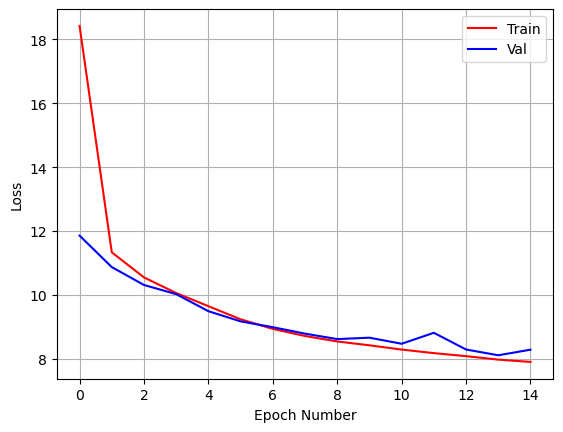

In [65]:
plt.plot(history.history['loss'],'-r',label="Train")
plt.plot(history.history['val_loss'],'-b',label='Val')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()

### We can see that train and val loss have reached an equilibrium...
Save the model so we can use it to predict

In [144]:
conv_model.save('{}/CNN_no_fancy_features.keras'.format(data_dir))

# Predict:

In [66]:
y_preds = conv_model.predict(ds_val)

750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [67]:
y_expected = y_v

In [68]:
y_e_avg = y_expected.mean(axis=0).load()

In [69]:
y_p_avg = y_preds.mean(axis=0)

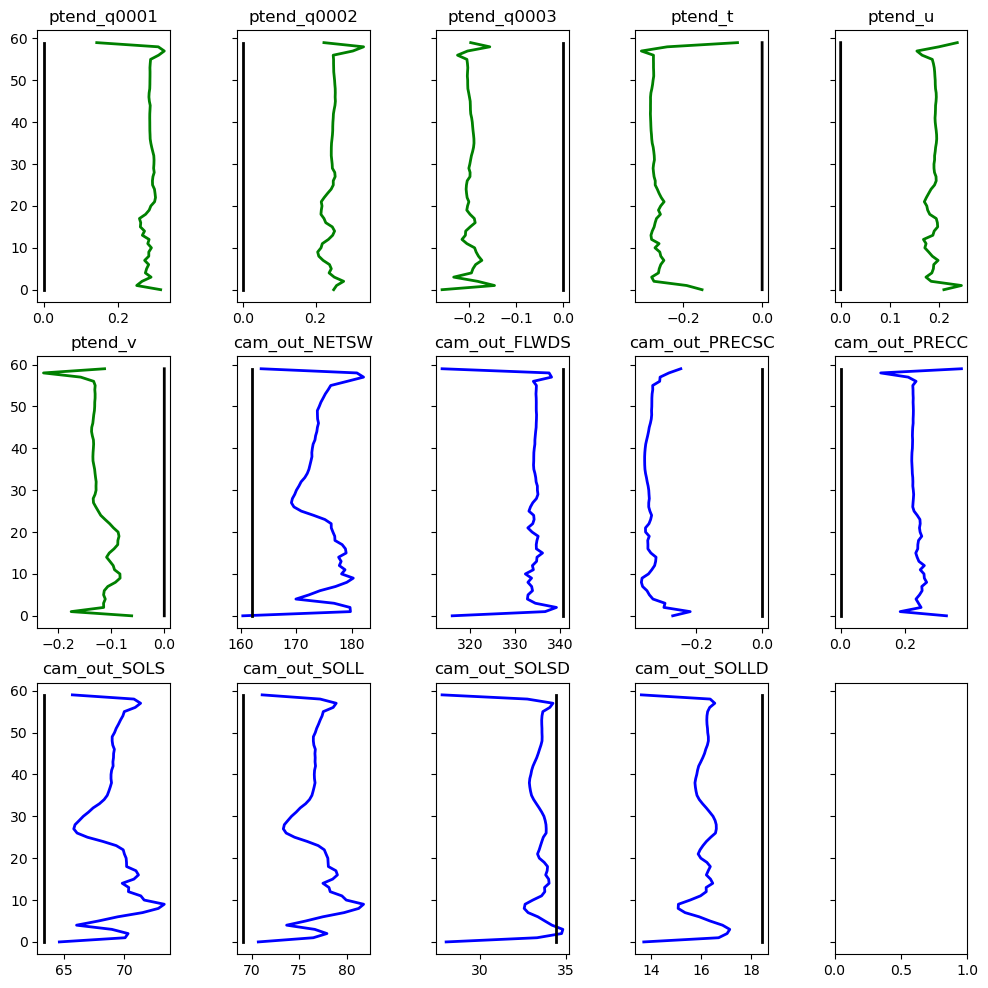

In [70]:
fig,ax = plt.subplots(ncols=5,nrows=3,sharey=True,figsize=(12,12))
plt.subplots_adjust(wspace=0.5)
row,col = 0,0
var_names = list(Y_val.data_vars)
for vv in range(14):
    pax = ax[row,col]
    if 'ptend' in var_names[vv]:
        c = 'g'
    else:
        c = 'b'
    pax.plot(y_p_avg[:,vv],np.arange(0,60),c=c,lw=2.0)
    pax.plot(y_e_avg[:,vv],np.arange(0,60),c='k',lw=2.0)
    pax.set_title(var_names[vv])
    col += 1
    if col == 5:
        col = 0
        row += 1
plt.show()


In [164]:
np.shape(y_p_avg)

(60, 14)

In [162]:
y_e_avg

<xarray.DataArray (level: 60, variable: 14)>
array([[-1.54503132e-16,  0.00000000e+00,  0.00000000e+00,
         1.19712235e-05,  0.00000000e+00,  0.00000000e+00,
         1.62016328e+02,  3.40549800e+02,  3.15477430e-09,
         2.79442474e-08,  6.32674641e+01,  6.90755195e+01,
         3.44495750e+01,  1.84405223e+01],
       [ 8.61468666e-17,  0.00000000e+00,  0.00000000e+00,
        -1.26130084e-05,  0.00000000e+00,  0.00000000e+00,
         1.62016328e+02,  3.40549800e+02,  3.15477430e-09,
         2.79442474e-08,  6.32674641e+01,  6.90755195e+01,
         3.44495750e+01,  1.84405223e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -6.72482875e-06,  0.00000000e+00,  0.00000000e+00,
         1.62016328e+02,  3.40549800e+02,  3.15477430e-09,
         2.79442474e-08,  6.32674641e+01,  6.90755195e+01,
         3.44495750e+01,  1.84405223e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.11568345e-06,  0.00000000e+00,  0.00000000e+00,
         1.62016328e+02,  3.40549800e+02,  3.15477430e-09,
         2.79442474e-08,  6.32674641e+01,  6.90755195e+01,
         3.44495750e+01,  1.84405223e+01],
...
       [-2.11233821e-08,  3.02857518e-11,  2.04359260e-11,
        -4.11247085e-07,  5.12055352e-06,  1.18075475e-06,
         1.62016328e+02,  3.40549800e+02,  3.15477430e-09,
         2.79442474e-08,  6.32674641e+01,  6.90755195e+01,
         3.44495750e+01,  1.84405223e+01],
       [-1.84161068e-08, -1.14504327e-10, -1.41432062e-11,
        -8.69352119e-06,  7.55511608e-06, -9.84350080e-07,
         1.62016328e+02,  3.40549800e+02,  3.15477430e-09,
         2.79442474e-08,  6.32674641e+01,  6.90755195e+01,
         3.44495750e+01,  1.84405223e+01],
       [-1.71720587e-08, -9.48615230e-11, -6.01335587e-11,
        -2.50013739e-05,  6.65085782e-06,  4.86610197e-07,
         1.62016328e+02,  3.40549800e+02,  3.15477430e-09,
         2.79442474e-08,  6.32674641e+01,  6.90755195e+01,
         3.44495750e+01,  1.84405223e+01],
       [-1.33066504e-08, -5.50207592e-10, -3.17498060e-10,
        -6.26930742e-05,  9.23419071e-06, -8.26965390e-07,
         1.62016328e+02,  3.40549800e+02,  3.15477430e-09,
         2.79442474e-08,  6.32674641e+01,  6.90755195e+01,
         3.44495750e+01,  1.84405223e+01]])
Coordinates:
  * variable  (variable) object 'ptend_q0001' 'ptend_q0002' ... 'cam_out_SOLLD'
Dimensions without coordinates: level

In [153]:
y_expected

<xarray.DataArray (point: 15000, level: 60, variable: 14)>
dask.array<transpose, shape=(15000, 60, 14), dtype=float64, chunksize=(5000, 60, 1), chunktype=numpy.ndarray>
Coordinates:
  * point     (point) int64 20000 20001 20002 20003 ... 34996 34997 34998 34999
  * variable  (variable) object 'ptend_q0001' 'ptend_q0002' ... 'cam_out_SOLLD'
Dimensions without coordinates: level

### Get scores:

In [152]:
conv_model.

<Sequential name=sequential_1, built=True>

In [151]:
# Getting our score for Test Dataset
test_score = conv_model.score(X_train_preprocessed,y_train)

# Getting our score for Train Dataset
train_score = conv_model.score(X_test_preprocessed, y_test)

print('Test score: {}'.format(test_score))
print('Train score: {}'.format(train_score))

AttributeError: 'Sequential' object has no attribute 'score'

In [30]:
proc_data_dir = os.path.join(data_dir,'processed_data')
test_x_files = sorted(glob.glob(os.path.join(proc_data_dir,'test_data_*')))

In [31]:
X_test = xr.open_mfdataset(test_x_files[:])

In [32]:
# Pre-Processing - Standard Scaling our Cleaned Features
X_test_scaled = X_test.copy()*1.0
scaler = StandardScaler()
for lvl in X_test.level:
    data = X_test.sel(level=lvl).to_array().T
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    for vv,varn in enumerate(list(X_test.data_vars)):
        X_test_scaled[varn].sel(level=lvl).data = scaled_data[:,vv]

In [ ]:
X_test = X_test_scaled.to_array().transpose('point','level','variable')

#make datasets 
ds_test = tf.data.Dataset.from_tensor_slices(X_test)

In [ ]:
# Pre-Processing our X_test data and calculating predictions using trained multi_model
predictions = conv_model.predict(X_test)
predictions

### Get scores:

In [ ]:
# Getting our score for Test Dataset
test_score = multi_model.score(X_test_preprocessed,y_test)

# Getting our score for Train Dataset
train_score = multi_model.score(X_train_preprocessed, y_train)

print('Test score: {}'.format(test_score))
print('Train score: {}'.format(train_score))

Test score: 0.11066071084394051
Train score: 0.10986737253212225


In [27]:
# Pre-Processing our Test Samples
test_dataframe_cleaned = np.delete(test_dataframe, deleted_columns, 1)
test_dataframe_preprocessed = scaler.transform(test_dataframe_cleaned)

In [28]:
# Getting the output from our trained model for the test samples
predictions = multi_model.predict(test_dataframe_preprocessed)
predictions

array([[-3.0655858e-06, -2.6985183e-05, -3.1835301e-05, ...,
         3.1487963e+00,  5.1059371e-01, -2.3283324e-01],
       [-3.0655858e-06, -2.6985183e-05, -3.1835301e-05, ...,
         5.0587374e-01,  2.6869051e+00,  5.5215228e-01],
       [-3.0655858e-06, -2.6985183e-05, -3.1835301e-05, ...,
         4.7205276e+00, -3.0602670e+00,  1.3390399e+00],
       ...,
       [ 2.3491733e-05,  8.7349090e-06,  2.8335207e-05, ...,
         4.8556156e+01,  6.1160892e+01,  3.4478981e+01],
       [ 2.3491733e-05,  8.7349090e-06,  2.8335207e-05, ...,
         1.5180273e+02,  6.1692001e+01,  2.5198324e+01],
       [ 2.3491733e-05,  8.7349090e-06,  2.8335207e-05, ...,
         6.3341293e+01,  4.6628708e+01,  3.8561638e+01]], dtype=float32)

# Get ready to submit:

In [31]:
submission = pd.read_csv(submission_file)

In [32]:
# Using the submission sample target values as weights 
submission.loc[:,y_columns] *= predictions
submission.loc[:, y_fixed_columns] *= np.mean(y_fixed.to_numpy(), axis=0)

In [33]:
# Outputting our submission file
file_name = 'leap_sub_'

existing_subs = sorted(glob.glob(os.path.join('./submissions','{}*.csv'.format(file_name))))
if existing_subs != []:
    last_sub = existing_subs[-1].split('_')[-1].replace('csv','')
else:
    last_sub = 0
    
new_sub = last_sub + 1
 
sub_file = os.path.join('./submissions','{0}{1:04d}.csv'.format(file_name,new_sub))
test_polars = pl.from_pandas(submission[["sample_id"]+TARGET_COLS])
test_polars.write_csv(sub_file)

In [92]:
proc_x_file_str = '_'.join(proc_x_files[0].split('_')[:-1])
print(proc_x_file_str)

/home/hawbecker/kaggle/LEAP/processed_data/train_data_X


In [93]:
proc_y_file_str = '_'.join(proc_y_files[0].split('_')[:-1])
print(proc_y_file_str)

/home/hawbecker/kaggle/LEAP/processed_data/train_data_Y


In [99]:
ds.level

<xarray.DataArray 'level' (level: 60)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59])
Dimensions without coordinates: level

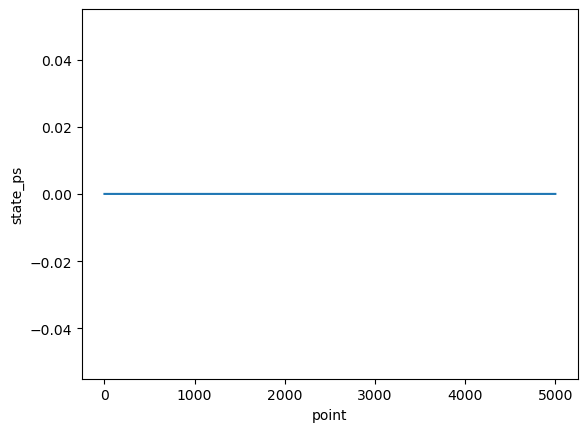

In [115]:
(float(bk[pp])*ds.state_ps.sel(level=pp)).plot()

In [127]:
for l in (bk.lev): print(float(l))

0.07834781133863082
0.1411083184744011
0.2529232969453412
0.4492506351686618
0.7863461614709879
1.3473557602677517
2.244777286900205
3.6164314830257718
5.615836425337344
8.403253219853443
12.144489352066294
17.016828024303006
23.21079811610005
30.914346261995327
40.277580662953575
51.37463234765765
64.18922841394662
78.63965761131159
94.63009200213703
112.09127353988006
130.97780378937776
151.22131809551237
172.67390465199267
195.08770981962772
218.15593476138105
241.60037901222947
265.2585152868483
289.12232222921756
313.31208711045167
338.0069992368819
363.37349177951705
389.5233382784413
416.5079218282233
444.3314120123719
472.9572063769364
502.2919169181905
532.1522731583445
562.2393924639011
592.1492760575118
621.4328411158061
649.689897132655
676.6564846051039
702.2421877859194
726.4985894989197
749.5376452869328
771.4452171682528
792.2342599534793
811.8566751313328
830.2596431972574
847.4506530638328
863.5359020075301
878.7158746040692
893.2460179738746
907.3852125876941
921.354

In [128]:
for l in (ak.lev): print(float(l))

0.07834781133863082
0.1411083184744011
0.2529232969453412
0.4492506351686618
0.7863461614709879
1.3473557602677517
2.244777286900205
3.6164314830257718
5.615836425337344
8.403253219853443
12.144489352066294
17.016828024303006
23.21079811610005
30.914346261995327
40.277580662953575
51.37463234765765
64.18922841394662
78.63965761131159
94.63009200213703
112.09127353988006
130.97780378937776
151.22131809551237
172.67390465199267
195.08770981962772
218.15593476138105
241.60037901222947
265.2585152868483
289.12232222921756
313.31208711045167
338.0069992368819
363.37349177951705
389.5233382784413
416.5079218282233
444.3314120123719
472.9572063769364
502.2919169181905
532.1522731583445
562.2393924639011
592.1492760575118
621.4328411158061
649.689897132655
676.6564846051039
702.2421877859194
726.4985894989197
749.5376452869328
771.4452171682528
792.2342599534793
811.8566751313328
830.2596431972574
847.4506530638328
863.5359020075301
878.7158746040692
893.2460179738746
907.3852125876941
921.354

In [123]:
bk.data[pp]

0.0

In [120]:
bk[pp].lev.data

array(0.07834781)

In [110]:
ds.state_ps.isel(point=0)

<xarray.DataArray 'state_ps' (level: 60)>
[60 values with dtype=float64]
Coordinates:
    point    int64 0
Dimensions without coordinates: level

In [130]:
float(bk[pp])*p0

0.0

In [133]:
np.shape(pres)

(5000, 60)

In [138]:
p0 = 100000
for ss,skip_rows in enumerate(range(0,total_len,max_locs)):
    fname = proc_x_file_str+'_{0:04d}.nc'.format(ss)
    ds = xr.open_dataset(fname)
    
    pres = (ds.state_u * 0.0 + 1)*0.0
    pres.name = 'state_p'
    for pp in ds.level:
        pp = int(pp)
        plvl = float(ak[pp])*p0 + float(bk[pp])*ds.state_ps.sel(level=pp).data
        pres[:,pp] = plvl
    
    ds['state_p'] = pres
    ds.to_netcdf(fname.replace('processed_data','processed_data/fixed'))
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/hawbecker/kaggle/LEAP/processed_data/train_data_X_0108.nc'

### Creates 3D data...
We don't really want 3D though because the dataset is 625000 points which means it doesn't evenly divide by the number of locations. 

Use 2D with ``[points,levels]``

In [159]:
def get_frame(frame_df,frame_num,frame_size=384,x_or_y=None):
    p0 = 100000
    p_levels = 60
    plvls = []
    for pp in range(p_levels):
        plvl = float(ak[pp])*p0 + float(bk[pp])*frame_df.state_ps
        frame_df['state_p_{}'.format(pp)] = plvl

    empty3d = np.zeros([frame_size,p_levels])

    # 3-D Variables:
    init_df = True
    for varn in vars_3d:
        data = empty3d.copy()
        for col in frame_df.columns:
            if varn in col:
                data_lvl = frame_df[col]
                lvl = int(col.split('_')[-1])
                data[:,lvl] = data_lvl.values
        data_da = xr.DataArray(data=data,name=varn,dims={'point':np.arange(0,frame_size),
                                                         'level':np.arange(0,p_levels)})
        if init_df:
            data_ds = data_da
            init_df = False
        else:
            data_ds = xr.merge([data_ds,data_da])

    # 2-D Variables:
    for col in vars_2d:
        #data = frame_df[col].values
        # Fill 2-D data so it looks 3d for convolution:
        if col in frame_df.columns:
            data = np.ones(np.shape(empty3d))*frame_df[col].values[:,None]
            data_da = xr.DataArray(data=data,name=col,dims={'point':np.arange(0,frame_size),
                                                             'level':np.arange(0,p_levels)})
            #data_da = xr.DataArray(data=data,name=col,dims={'point':np.arange(0,frame_size)})
            data_ds = xr.merge([data_ds,data_da])

    data_ds = data_ds.expand_dims({'frame':[frame_num]})
    if x_or_y == 'x':
        data_ds = data_ds[Xvars_3d + Xvars_2d]
    else:
        data_ds = data_ds[Yvars_3d + Yvars_2d]
        
    return(data_ds)

In [163]:
def get_data(data_file,max_frames=None,get_y=True):
    with open(data_file,'r') as f:
        header = f.readline().replace('\n','').split(',')

        init_frame = True
        ind_count = 0
        frame_count = 0
        frame = []

        for line in f:
            line = np.asarray(line.split(',')[1:],dtype=np.float32)
            ind_count += 1
            if init_frame:
                frame = line
                init_frame = False
            else:
                frame = np.vstack([frame,line])
            if ind_count == frame_size:
                frame_df = pd.DataFrame(data=frame,columns=header[1:],dtype=np.float32)
                if frame_count == 0:
                    X_ds = get_frame(frame_df,frame_count,x_or_y='x')
                    if get_y:
                        Y_ds = get_frame(frame_df,frame_count,x_or_y='y')

                else:
                    X_ds = xr.merge([X_ds,get_frame(frame_df,frame_count,x_or_y='x')])
                    if get_y:
                        Y_ds = xr.merge([Y_ds,get_frame(frame_df,frame_count,x_or_y='y')])
                ind_count = 0
                frame = []
                frame_count += 1
                init_frame = True
            if frame_count == max_frames:
                break
    if get_y:
        return(X_ds,Y_ds)
    else:
        return(X_ds)

max_frames = 10
x,y = get_data(train_data_file,max_frames=max_frames)

In [121]:
# Pre-Processing - Deleting Feature Columns with 0 or almost 0 standard deviation 
deleted_columns = np.where(np.std(X_ds, axis=(0,1,2)) < 1e-6)[0]
print(deleted_columns)

X_train_cleaned = np.delete(X_t, deleted_columns, 3)
print(X_train_cleaned.shape)
# Pre-Processing - Standard Scaling our Cleaned Features
scaler = StandardScaler()
scaler.fit(X_train_cleaned)
X_train_preprocessed = scaler.transform(X_train_cleaned)

[0 1]
(384, 75, 60, 23)


ValueError: Found array with dim 4. StandardScaler expected <= 2.

In [7]:
test_df = pl.read_csv(test_data_file)

for col in FEAT_COLS:
    test_dataframe = test_df.select(FEAT_COLS).with_columns(pl.col(col).cast(pl.Float32))

test_dataframe = test_dataframe.to_numpy()

print(test_dataframe.shape)

(625000, 556)


## Check sample dataset
Interesting to see the data spatially

### Get data for training and necessary columns:

In [ ]:
X = data.select(FEAT_COLS)
y = data.select(TARGET_COLS)

# Converting Data from F64 to F32 Format
for col in FEAT_COLS:
    X = X.with_columns(pl.col(col).cast(pl.Float32))
for col in TARGET_COLS:
    y = y.with_columns(pl.col(col).cast(pl.Float32))
    
y_fixed = y.select(fixed_targets)
y = y.drop(fixed_targets)

# To be used during Submission
y_columns = y.columns
y_fixed_columns = y_fixed.columns

In [ ]:
print(y_fixed.shape)
print(y.shape)

### Divide the given test data into training and testing:

In [ ]:
X, y = X.to_numpy(), y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

### Remove undesireable features and scale:

In [ ]:
# Pre-Processing - Deleting Feature Columns with 0 or almost 0 standard deviation 
deleted_columns = np.where(np.std(X_train, axis=0) < 1e-6)[0]
X_train_cleaned = np.delete(X_train, deleted_columns, 1)
print(X_train_cleaned.shape)
# Pre-Processing - Standard Scaling our Cleaned Features
scaler = StandardScaler()
scaler.fit(X_train_cleaned)
X_train_preprocessed = scaler.transform(X_train_cleaned)

# Create ML model:

### XGBoost:

In [19]:
model = XGBRegressor(tree_method='hist', device="cpu")
multi_model = MultiOutputRegressor(model)

In [20]:
%%time
multi_model.fit(X_train_preprocessed, y_train)

CPU times: user 9min 7s, sys: 3.58 s, total: 9min 11s
Wall time: 1min 31s


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device='cpu',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [35]:
X_train_preprocessed.shape

(3401, 318)

In [36]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Dense(2,activation='relu',input_shape=(X_train_preprocessed.shape[1],),),
        #hidden layer 1
        tf.keras.layers.Dense(2,activation='relu'),
        #output layer 
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

NameError: name 'tf' is not defined

# Predict:

In [22]:
# Pre-Processing our X_test data and calculating predictions using trained multi_model
X_test_cleaned = np.delete(X_test, deleted_columns, 1)
X_test_preprocessed = scaler.transform(X_test_cleaned)
predictions = multi_model.predict(X_test_preprocessed)
predictions

array([[ 2.34917334e-05, -3.89491743e-06,  2.83352074e-05, ...,
         1.26476316e+01,  3.23456230e+01,  1.77827816e+01],
       [-3.06558582e-06, -2.69851826e-05, -3.18353013e-05, ...,
         4.29110003e+00,  1.93754578e+00, -9.86183524e-01],
       [ 2.34917334e-05, -3.89491743e-06,  2.83352074e-05, ...,
         7.85923538e+01,  6.70680771e+01,  4.27106056e+01],
       ...,
       [ 2.34917334e-05,  8.73490899e-06,  2.83352074e-05, ...,
         1.58715315e+01,  2.58332481e+01,  1.11273766e+01],
       [-3.06558582e-06, -2.69851826e-05, -3.18353013e-05, ...,
        -5.90545177e-01,  5.92517495e-01, -3.07107151e-01],
       [ 2.34917334e-05,  8.73490899e-06,  2.83352074e-05, ...,
         1.18689995e+02,  1.14186806e+02,  5.39898071e+01]], dtype=float32)

### Get scores:

In [ ]:
# Getting our score for Test Dataset
test_score = multi_model.score(X_test_preprocessed,y_test)

# Getting our score for Train Dataset
train_score = multi_model.score(X_train_preprocessed, y_train)

print('Test score: {}'.format(test_score))
print('Train score: {}'.format(train_score))

Test score: 0.11066071084394051
Train score: 0.10986737253212225


In [27]:
# Pre-Processing our Test Samples
test_dataframe_cleaned = np.delete(test_dataframe, deleted_columns, 1)
test_dataframe_preprocessed = scaler.transform(test_dataframe_cleaned)

In [28]:
# Getting the output from our trained model for the test samples
predictions = multi_model.predict(test_dataframe_preprocessed)
predictions

array([[-3.0655858e-06, -2.6985183e-05, -3.1835301e-05, ...,
         3.1487963e+00,  5.1059371e-01, -2.3283324e-01],
       [-3.0655858e-06, -2.6985183e-05, -3.1835301e-05, ...,
         5.0587374e-01,  2.6869051e+00,  5.5215228e-01],
       [-3.0655858e-06, -2.6985183e-05, -3.1835301e-05, ...,
         4.7205276e+00, -3.0602670e+00,  1.3390399e+00],
       ...,
       [ 2.3491733e-05,  8.7349090e-06,  2.8335207e-05, ...,
         4.8556156e+01,  6.1160892e+01,  3.4478981e+01],
       [ 2.3491733e-05,  8.7349090e-06,  2.8335207e-05, ...,
         1.5180273e+02,  6.1692001e+01,  2.5198324e+01],
       [ 2.3491733e-05,  8.7349090e-06,  2.8335207e-05, ...,
         6.3341293e+01,  4.6628708e+01,  3.8561638e+01]], dtype=float32)

# Get ready to submit:

In [31]:
submission = pd.read_csv(submission_file)

In [32]:
# Using the submission sample target values as weights 
submission.loc[:,y_columns] *= predictions
submission.loc[:, y_fixed_columns] *= np.mean(y_fixed.to_numpy(), axis=0)

In [33]:
# Outputting our submission file
file_name = 'leap_sub_'

existing_subs = sorted(glob.glob(os.path.join('./submissions','{}*.csv'.format(file_name))))
if existing_subs != []:
    last_sub = existing_subs[-1].split('_')[-1].replace('csv','')
else:
    last_sub = 0
    
new_sub = last_sub + 1
 
sub_file = os.path.join('./submissions','{0}{1:04d}.csv'.format(file_name,new_sub))
test_polars = pl.from_pandas(submission[["sample_id"]+TARGET_COLS])
test_polars.write_csv(sub_file)

# OLD:

### CNN (from paper)

In [ ]:
cfg['in_shape'] = e3smdataset.in_shape[1:] # e.g., 60,6
cfg['out_shape'] = e3smdataset.out_shape[1:] # e.g., 60, 10
cfg['n_vertical_vars'] = 2 # Number of vertically resolved variables. Todo get rid of hardcoding. 
cfg['channel_dims'] = [32, 64, 128, 256] # Number of features in each convolutional block. Length determines number of blocks.
cfg['kernels'] = [5] # kernel_size in each convolutional block. Is either of same length as channel_dims or first entry is used for every layer.
cfg['activation'] = 'gelu' # Activation for all internal layers
cfg['pre_out_activation'] = 'elu' # Activation right before output activation. Not sure why fcnn used elu and not gelu here.
cfg['loss'] = 'mse'
cfg['lr'] = 0.001
cfg['epsilon'] = 1e-7 # Small constant in adam for numerical stability. Default value is 1e-07. But keras mentions that other papers use 1.0 or 0.1
cfg['weight_decay'] = 1e-6
cfg['norm'] = None # Can use 'layer_norm', 'batch_norm', None
cfg['dropout'] = 0.0 # Dropout probability in range [0,1]
cfg['verbose'] = True

model = init_cnn(in_shape=cfg['in_shape'],
        out_shape=cfg['out_shape'],
        n_vertical_vars=cfg['n_vertical_vars'],
        channel_dims=cfg['channel_dims'],
        kernels=cfg['kernels'],
        activation=cfg['activation'],
        norm=cfg['norm'],
        dropout=cfg['dropout']
)
if cfg['verbose']:
    model.summary()

# todo add lr scheduler.
# clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
#                                      maximal_learning_rate=MAX_LR,
#                                      scale_fn=lambda x: 1/(2.**(x-1)),
#                                       step_size= 2 * steps_per_epoch,
#                                       scale_mode = 'cycle'
#                                      )

optimizer = tf.keras.optimizers.Adam(
    learning_rate=cfg['lr'],
    epsilon=cfg['epsilon'],
    weight_decay=cfg['weight_decay'])

loss = cfg['loss']

model.compile(optimizer=optimizer, #
              loss=loss,
              metrics=['mse','mae','accuracy'])

In [4]:
frame_size = 384 # From the test file
frame_stride = 100 # How many frames to skip
total_len = 625000 # size of training set
total_frames = np.floor(total_len/frame_size)
frames_to_use = np.arange(0,total_frames,frame_stride)
print(len(frames_to_use))

17


In [9]:
%%time
test_df = pd.read_csv(test_data_file)
submission = pd.read_csv(submission_file)

train_df.head()

AttributeError: 'BatchedCsvReader' object has no attribute 'head'

In [5]:
use_rows = []
for frame in frames_to_use:
    t_start = frame*frame_size
    t_end = (frame+1)*frame_size
    frame_rows = list(np.arange(t_start,t_end,dtype=int))
    use_rows += frame_rows

In [6]:
skip_rows = np.arange(0,total_len,dtype=int)
skip_rows = np.delete(skip_rows, use_rows)

In [7]:
print('Use: {}\nSkip: {}\nTotal: {}'.format(len(use_rows),len(skip_rows),len(use_rows)+len(skip_rows)))

Use: 6528
Skip: 618472
Total: 625000


### Drop the sample ID column

In [4]:
train_df = train_df.drop(['sample_id'],axis=1)
test_df = test_df.drop(['sample_id'],axis=1)
submission = submission.drop(["sample_id"], axis=1)

### Get features and targets:

In [5]:
target_col = submission.columns

X_train = train_df.drop(target_col,axis=1)
Y_train = train_df[target_col]

In [15]:
target_col

Index(['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4',
       'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9',
       ...
       'ptend_v_58', 'ptend_v_59', 'cam_out_NETSW', 'cam_out_FLWDS',
       'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL',
       'cam_out_SOLSD', 'cam_out_SOLLD'],
      dtype='object', length=368)

In [22]:
train_df

,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,state_t_35,state_t_36,state_t_37,state_t_38,state_t_39,state_t_40,state_t_41,state_t_42,state_t_43,state_t_44,state_t_45,state_t_46,state_t_47,state_t_48,state_t_49,state_t_50,state_t_51,state_t_52,state_t_53,state_t_54,state_t_55,state_t_56,state_t_57,state_t_58,state_t_59,state_q0001_0,state_q0001_1,state_q0001_2,state_q0001_3,state_q0001_4,state_q0001_5,state_q0001_6,state_q0001_7,state_q0001_8,state_q0001_9,state_q0001_10,state_q0001_11,state_q0001_12,state_q0001_13,state_q0001_14,state_q0001_15,state_q0001_16,state_q0001_17,state_q0001_18,state_q0001_19,state_q0001_20,state_q0001_21,state_q0001_22,state_q0001_23,state_q0001_24,state_q0001_25,state_q0001_26,state_q0001_27,state_q0001_28,state_q0001_29,state_q0001_30,state_q0001_31,state_q0001_32,state_q0001_33,state_q0001_34,state_q0001_35,state_q0001_36,state_q0001_37,state_q0001_38,state_q0001_39,state_q0001_40,state_q0001_41,state_q0001_42,state_q0001_43,state_q0001_44,state_q0001_45,state_q0001_46,state_q0001_47,state_q0001_48,state_q0001_49,state_q0001_50,state_q0001_51,state_q0001_52,state_q0001_53,state_q0001_54,state_q0001_55,state_q0001_56,state_q0001_57,state_q0001_58,state_q0001_59,state_q0002_0,state_q0002_1,state_q0002_2,state_q0002_3,state_q0002_4,state_q0002_5,state_q0002_6,state_q0002_7,state_q0002_8,state_q0002_9,state_q0002_10,state_q0002_11,state_q0002_12,state_q0002_13,state_q0002_14,state_q0002_15,state_q0002_16,state_q0002_17,state_q0002_18,state_q0002_19,state_q0002_20,state_q0002_21,state_q0002_22,state_q0002_23,state_q0002_24,state_q0002_25,state_q0002_26,state_q0002_27,state_q0002_28,state_q0002_29,state_q0002_30,state_q0002_31,state_q0002_32,state_q0002_33,state_q0002_34,state_q0002_35,state_q0002_36,state_q0002_37,state_q0002_38,state_q0002_39,state_q0002_40,state_q0002_41,state_q0002_42,state_q0002_43,state_q0002_44,state_q0002_45,state_q0002_46,state_q0002_47,state_q0002_48,state_q0002_49,state_q0002_50,state_q0002_51,state_q0002_52,state_q0002_53,state_q0002_54,state_q0002_55,state_q0002_56,state_q0002_57,state_q0002_58,state_q0002_59,state_q0003_0,state_q0003_1,state_q0003_2,state_q0003_3,state_q0003_4,state_q0003_5,state_q0003_6,state_q0003_7,state_q0003_8,state_q0003_9,state_q0003_10,state_q0003_11,state_q0003_12,state_q0003_13,state_q0003_14,state_q0003_15,state_q0003_16,state_q0003_17,state_q0003_18,state_q0003_19,state_q0003_20,state_q0003_21,state_q0003_22,state_q0003_23,state_q0003_24,state_q0003_25,state_q0003_26,state_q0003_27,state_q0003_28,state_q0003_29,state_q0003_30,state_q0003_31,state_q0003_32,state_q0003_33,state_q0003_34,state_q0003_35,state_q0003_36,state_q0003_37,state_q0003_38,state_q0003_39,state_q0003_40,state_q0003_41,state_q0003_42,state_q0003_43,state_q0003_44,state_q0003_45,state_q0003_46,state_q0003_47,state_q0003_48,state_q0003_49,state_q0003_50,state_q0003_51,state_q0003_52,state_q0003_53,state_q0003_54,state_q0003_55,state_q0003_56,state_q0003_57,state_q0003_58,state_q0003_59,state_u_0,state_u_1,state_u_2,state_u_3,state_u_4,state_u_5,state_u_6,state_u_7,state_u_8,state_u_9,state_u_10,state_u_11,state_u_12,state_u_13,state_u_14,state_u_15,state_u_16,state_u_17,state_u_18,state_u_19,state_u_20,state_u_21,state_u_22,state_u_23,state_u_24,state_u_25,state_u_26,state_u_27,state_u_28,state_u_29,state_u_30,state_u_31,state_u_32,state_u_33,state_u_34,state_u_35,state_u_36,state_u_37,state_u_38,state_u_39,state_u_40,state_u_41,state_u_42,state_u_43,state_u_44,state_u_45,state_u_46,state_u_47,state_u_48,state_u_49,state_u_50,state_u_51,state_u_52,state_u_53,state_u_54,state_u_55,state_u_56,state_u_57,state_u_58,state_u_59,state_v_0,state_v_1,state_v_2

In [18]:
test_df.head(2)

,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,...,pbuf_N2O_50,pbuf_N2O_51,pbuf_N2O_52,pbuf_N2O_53,pbuf_N2O_54,pbuf_N2O_55,pbuf_N2O_56,pbuf_N2O_57,pbuf_N2O_58,pbuf_N2O_59
0,209.802593,220.698213,227.783289,241.386812,254.602962,262.319063,261.308368,254.062035,243.904420,236.302401,...,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07
1,208.366101,219.238711,228.265017,242.099772,256.164270,263.783211,261.835384,253.636172,243.783467,236.961625,...,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07


In [ ]:
test_df.p

In [6]:
X_test = test_df.drop(target_col,axis=1)
Y_test = test_df[target_col]

ValueError: Metadata inference failed in `drop_by_shallow_copy`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
KeyError("['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59', 'ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59', 'ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59', 'ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59', 'ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59', 'ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD'] not found in axis")

Traceback:
---------
  File "/home/hawbecker/miniconda3/envs/pyhawbeck/lib/python3.11/site-packages/dask/dataframe/utils.py", line 194, in raise_on_meta_error
    yield
  File "/home/hawbecker/miniconda3/envs/pyhawbeck/lib/python3.11/site-packages/dask/dataframe/core.py", line 7055, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hawbecker/miniconda3/envs/pyhawbeck/lib/python3.11/site-packages/dask/dataframe/utils.py", line 773, in drop_by_shallow_copy
    df2.drop(columns=columns, inplace=True, errors=errors)
  File "/home/hawbecker/miniconda3/envs/pyhawbeck/lib/python3.11/site-packages/pandas/core/frame.py", line 5344, in drop
    return super().drop(
           ^^^^^^^^^^^^^
  File "/home/hawbecker/miniconda3/envs/pyhawbeck/lib/python3.11/site-packages/pandas/core/generic.py", line 4711, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hawbecker/miniconda3/envs/pyhawbeck/lib/python3.11/site-packages/pandas/core/generic.py", line 4753, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hawbecker/miniconda3/envs/pyhawbeck/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 7000, in drop
    raise KeyError(f"{labels[mask].tolist()} not found in axis")


### Drop unwanted variables:

In [ ]:
sample_X_train = X_train.head(2000)

# Pre-Processing - Deleting Feature Columns with 0 or almost 0 standard deviation 
deleted_columns = np.where(np.std(sample_X_train, axis=0) < 1e-6)[0]
X_train_cleaned = np.delete(X_train, deleted_columns, 1)
print(X_train_cleaned.shape)

### Scale the features:

In [ ]:
# Pre-Processing - Standard Scaling our Cleaned Features
scaler = StandardScaler()
scaler.fit(X_train_cleaned)
X_train_preprocessed = scaler.transform(X_train_cleaned)

### Repeat for test data:

In [ ]:
X_test_cleaned = np.delete(X_test, deleted_columns, 1)
X_test_preprocessed = scaler.transform(X_test_cleaned)

# Start ML

In [ ]:
# Defining our XGBRegressor model to be computed using GPU
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

model = XGBRegressor(tree_method='hist', device="cuda")
multi_model = MultiOutputRegressor(model)

In [ ]:
%%time
multi_model.fit(X_train_preprocessed, y_train)

In [ ]:
# Pre-Processing our X_test data and calculating predictions using trained multi_model
predictions = multi_model.predict(X_test_preprocessed)
predictions

In [ ]:
# Getting our score for Test Dataset
multi_model.score(X_test_preprocessed,y_test)

In [ ]:
# Getting our score for Train Dataset
multi_model.score(X_train_preprocessed, y_train)

#### From the LEAP paper:

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# model params
input_length = 2*60 + 4
output_length_lin  = 2*60
output_length_relu = 8
output_length = output_length_lin + output_length_relu
n_nodes = 512

# constrcut a model
input_layer    = keras.layers.Input(shape=(input_length,), name='input')
hidden_0       = keras.layers.Dense(n_nodes, activation='relu')(input_layer)
hidden_1       = keras.layers.Dense(n_nodes, activation='relu')(hidden_0)
output_pre     = keras.layers.Dense(output_length, activation='elu')(hidden_1)
output_lin     = keras.layers.Dense(output_length_lin,activation='linear')(output_pre)
output_relu    = keras.layers.Dense(output_length_relu,activation='relu')(output_pre)
output_layer   = keras.layers.Concatenate()([output_lin, output_relu])

model = keras.Model(input_layer, output_layer, name='Emulator')
model.summary()

# compile
model.compile(optimizer=keras.optimizers.Adam(), #optimizer=keras.optimizers.Adam(learning_rate=clr),
              loss='mse',
              metrics=['mse','mae','accuracy'])